<a href="https://colab.research.google.com/github/Sparadrap1101/Project-ML/blob/main/Projet_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Machine Learning

Bonjour, voici mon projet de Machine Learning pour cette fin de semestre.

Le sujet que j'ai choisi est la prédiction du cours d'une cryptomonnaie.

#  -

*Alexis CERIO*

*ESILV Fintech A4*

In [ ]:
!pip install pandas-ta # Installation si nécessaire pour un module importé plus tard
import requests
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt

BaseURL = 'https://api.binance.com'

     |████████████████████████████████| 115 kB 5.1 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=a8d7543058ac68acbc578a4097e9b09acdd757266a114c6ee12be3817e7c075c
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [ ]:
crypto = input("Quelle crypto choisissez vous pour la prédiction ? > ")

Quelle crypto choisissez vous pour la prédiction ? > btc


In [ ]:
r = requests.get(BaseURL + "/api/v3/exchangeInfo") # On récupère les données depuis l'API de Binance
results = r.json()

loop = True
while loop == True: # On vérifie que la crypto entrée par le user fait bien partie de celles dispo sur Binance
  for baseAsset in results['symbols']: 
    if baseAsset['baseAsset'] == crypto.upper(): # Si la crypto existe on sort de la boucle
      loop = False 
  if loop == True: # Si la crypto n'existe pas on redemande
    print("Cette crypto n'est pas disponible sur Binance") 
    crypto = input("Veuillez choisir une nouvelle crypto (Try 'btc', 'eth', ...) > ")

symbol = crypto.upper() + "USDT" # On rajoute USDT pour avoir le symbol de la pair
print(symbol)

BTCUSDT


In [ ]:
r = requests.get(BaseURL + "/api/v3/klines", params={'symbol': symbol, 'interval': "1d", 'limit': 1000}) # On récupère les données des candles de notre crypto depuis l'API Binance
results = r.json()

dataCandle = [[], [], [], [], [], [], [], []]
for data in results: # On sélectionne les données qui nous intéressent
  dataCandle[0].append(datetime.datetime.fromtimestamp(data[0]/1000)) # On transforme le timestamp en date lisible
  dataCandle[1].append(round(float(data[1]), 2)) # On arrondie les valeurs à 2 décimales près
  dataCandle[2].append(round(float(data[2]), 2))
  dataCandle[3].append(round(float(data[3]), 2))
  dataCandle[4].append(round(float(data[4]), 2))
  dataCandle[5].append(round(float(data[5]), 2))
  dataCandle[6].append(datetime.datetime.fromtimestamp((data[6] - 999)/1000)) # On transforme le timestamp en date lisible
  dataCandle[7].append(data[8])

# On crée un DataFrame avec Pandas
df = pd.DataFrame({"Open Time":dataCandle[0],
                  "Open Price":dataCandle[1],
                  "High":dataCandle[2],
                  "Low":dataCandle[3],
                  "Close Price":dataCandle[4],
                  "Volume":dataCandle[5],
                  "Close Time":dataCandle[6],
                  "Nbre of trade":dataCandle[7]})

df.set_index(pd.DatetimeIndex(df['Open Time']), inplace=True) # On place la date en index

In [ ]:
# On print qq infos brutes
print(df.shape)
df.info()
df.head()

(1000, 8)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2019-04-14 to 2022-01-07
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Open Time      1000 non-null   datetime64[ns]
 1   Open Price     1000 non-null   float64       
 2   High           1000 non-null   float64       
 3   Low            1000 non-null   float64       
 4   Close Price    1000 non-null   float64       
 5   Volume         1000 non-null   float64       
 6   Close Time     1000 non-null   datetime64[ns]
 7   Nbre of trade  1000 non-null   int64         
dtypes: datetime64[ns](2), float64(5), int64(1)
memory usage: 70.3 KB


,Open Time,Open Price,High,Low,Close Price,Volume,Close Time,Nbre of trade
Open Time,,,,,,,,
2019-04-14,2019-04-14,5047.45,5152.99,5000.00,5131.30,18281.61,2019-04-14 23:59:59,131700
2019-04-15,2019-04-15,5131.28,5167.38,4950.00,5024.95,29057.19,2019-04-15 23:59:59,204944
2019-04-16,2019-04-16,5024.95,5197.72,5003.94,5173.72,24242.23,2019-04-16 23:59:59,168550
2019-04-17,2019-04-17,5173.72,5230.40,5146.80,5202.82,23307.54,2019-04-17 23:59:59,179490
2019-04-18,2019-04-18,5202.41,5287.00,5198.80,5258.44,22619.24,2019-04-18 23:59:59,167110


Voici les infos en brut de nos données que l'on va mettre en forme par la suite.

On peut remarquer entre autre qu'il y a 1.000 lignes (limite maximale de l'API Binance) et que chaque ligne correspond à une journée.


---

Affichons ces données sous forme graphique :

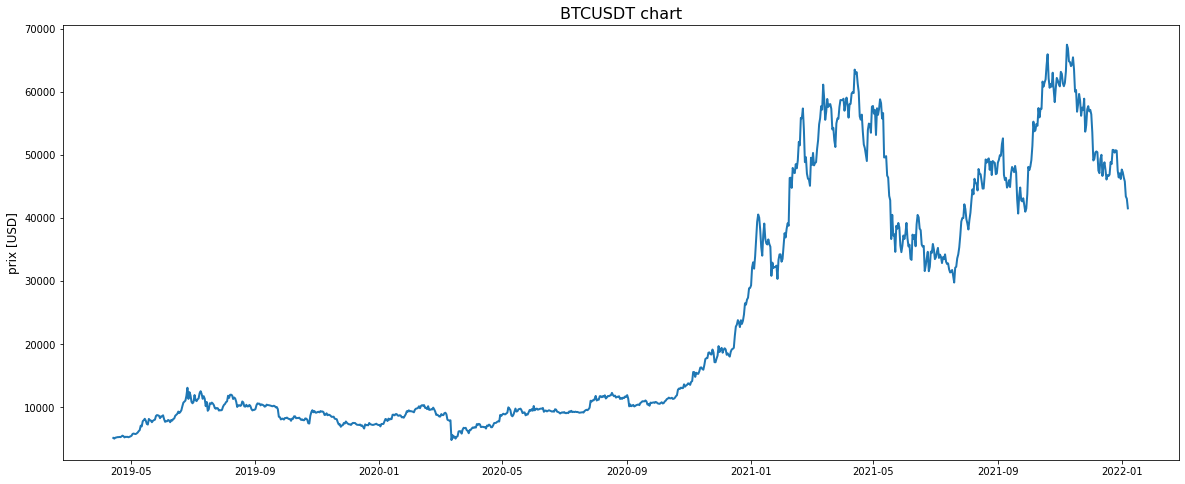

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.plot(df['Close Price'], linewidth=2)
ax.set_ylabel('prix [USD]', fontsize=12)
ax.set_title(symbol + " chart", fontsize=16)
plt.show()

Voici le cours de la cryptomonnaie contre le Dollar d'après les données extraites de l'API de Binance et mises en forme.



---


On va maintenant chercher à prédire le cours de cette cryptomonnaie. Pour cela nous allons nous aider d'un indicateur technique, la EMA 10 qui représente la moyenne des 10 dernières périodes de cette cryptomonnaie.

Commençons par récupérer l'EMA 10 grâce à la librairie pandas_ta regroupant de nombreux indicateurs techniques.

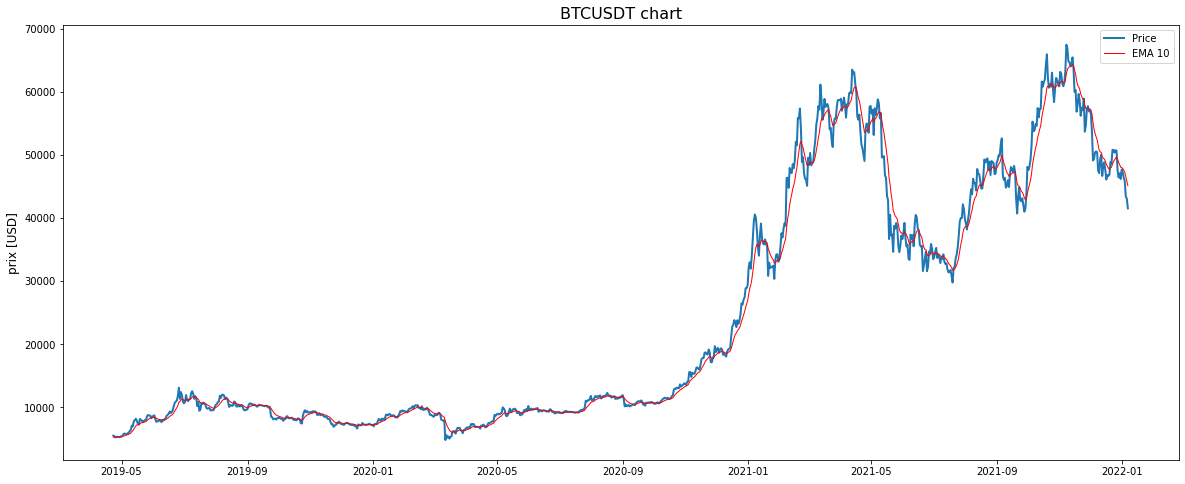

In [ ]:
import pandas_ta

df_use = df[["Close Price"]].copy() # On récupère uniquement le Close Price de notre DataFrame df
df_use.ta.ema(close='Close Price', length=10, append=True) # On y ajoute les données de l'EMA 10

df_used = df_use.iloc[9:] # On supprime les 10 premières lignes de notre nouveau DataFrame car elles sont en NaN pour l'EMA 10

# On peut maintenant afficher le cours avec l'indicateur technique par dessus
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.plot(df_used['Close Price'], linewidth=2, label="Price")
ax.set_ylabel('prix [USD]', fontsize=12)
ax.plot(df_used['EMA_10'], linewidth=1, color='r', label="EMA 10")
ax.set_title(symbol + " chart", fontsize=16)
ax.legend()
plt.show()

Voici le cours de la cryptomonnaie en fonction du Dollar avec l'indicateur technique EMA 10 en rouge.




---




Maintenant que tout est prêt nous allons pouvoir passer à la partie Machine Learning. Nous allons utiliser une Régression Linéaire pour notre projet grâce à la librairie SkLearn.

Comme réalisé ci-dessous, nous commençons par séparer le dataset en deux parties :

*   80% du dataset servira à l'entrainement du model
*   20% du dataset servira au test du model

Pour la séparation j'ai choisi de garder les données les plus récentes pour le test.


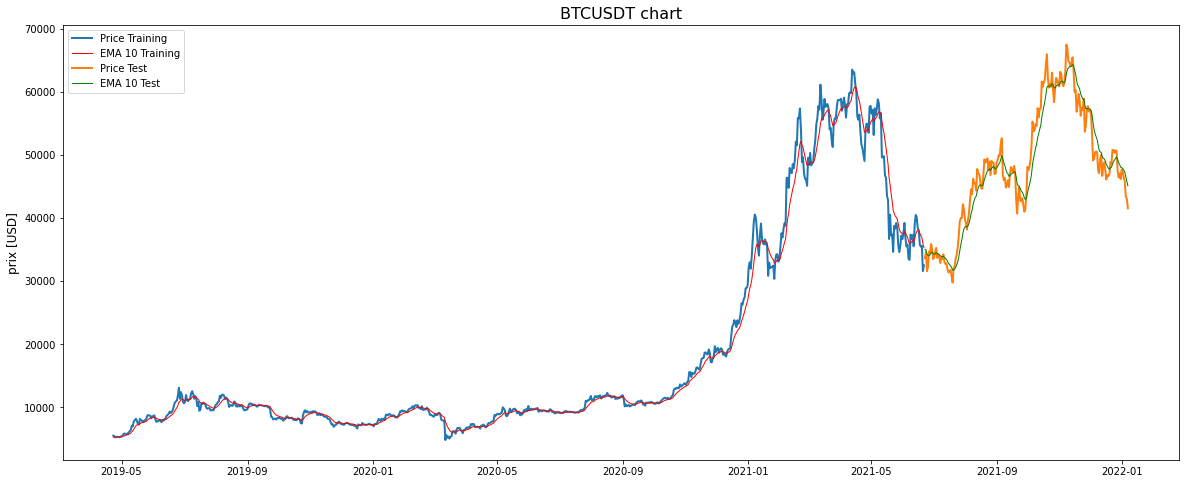

In [ ]:
from sklearn.model_selection import train_test_split # Cette librairie sert à split automatiquement les données d'un dataset 
                                                     # mais j'ai finalement choisi de ne pas l'utiliser et de split à la main.

#X_train, X_test, y_train, y_test = train_test_split(df_used[['Close Price']], df_used[['EMA_10']], test_size=0.2)
# On split le dataset en deux parties
taille_train = (len(df_used['Close Price']) / 100) * 80
X_train = df_used[['Close Price']].iloc[:int(taille_train)]
y_train = df_used[['EMA_10']].iloc[:int(taille_train)]
X_test = df_used[['Close Price']].iloc[int(taille_train):]
y_test = df_used[['EMA_10']].iloc[int(taille_train):]

# On affiche les deux parties pour y voir plus clair
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.plot(X_train, linewidth=2, label="Price Training")
ax.plot(y_train, linewidth=1, color='r', label="EMA 10 Training")
ax.set_ylabel('prix [USD]', fontsize=12)
ax.plot(X_test, linewidth=2, label="Price Test")
ax.plot(y_test, linewidth=1, color='green', label="EMA 10 Test")
ax.set_title(symbol + " chart", fontsize=16)
ax.legend()
plt.show()

Avec ce graphique nous pouvons bien différencier les données de Training à gauche des données de Test à droite.

---

Il est maintenant l'heure de créer puis de tester notre modèle.

In [ ]:
from sklearn.linear_model import LinearRegression # On importe les librairies nécessaires
from sklearn.metrics import r2_score, mean_absolute_error

model = LinearRegression() # On crée notre modèle
model.fit(X_train, y_train) # On l'entraine sur les données d'entrainement sélectionnées auparavant
y_pred = model.predict(X_test) # Une fois que le modèle est entrainé, nous pouvons lui passer les données de test pour qu'il nous sorte sa prédiction

# On vérifie ensuite l'accuracy de notre modèle grâce à ces différents coefficients :
print("Coefficient du model :", model.coef_)
print("Erreur absolue moyenne (MAE) :", mean_absolute_error(y_test, y_pred))
print("Coefficient de determination (r²) :", r2_score(y_test, y_pred))

Coefficient du model : [[0.98806743]]
Erreur absolue moyenne (MAE) : 1839.8253934870722
Coefficient de determination (r²) : 0.9389254731581385


On peut maintenant interpréter les résultats.

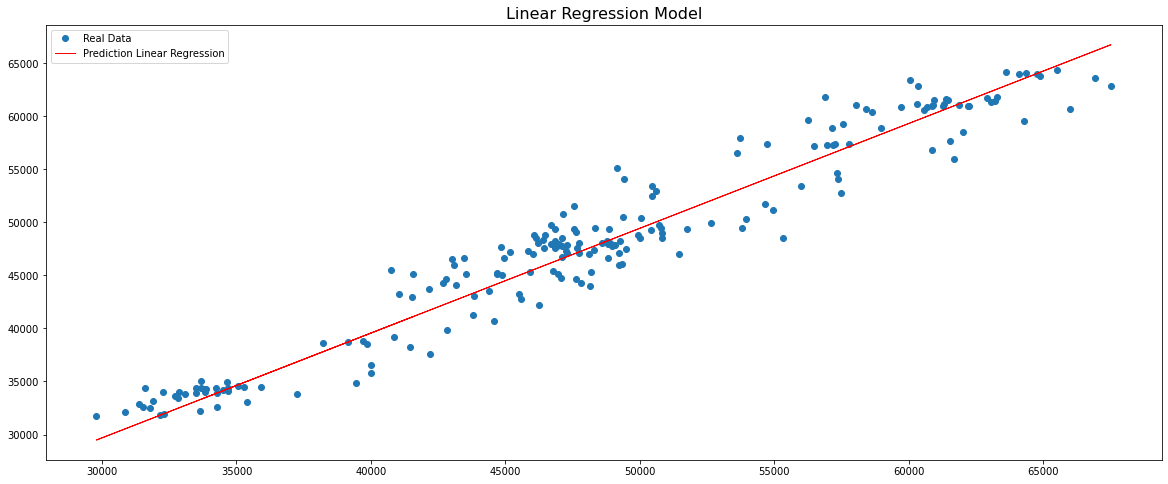

In [ ]:
# On affiche les résultats de notre modèle de régression linéaire
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.plot(X_test, y_test, 'o', label="Real Data")
ax.plot(X_test, y_pred, linewidth=1, label="Prediction Linear Regression", color='r')
ax.set_title("Linear Regression Model", fontsize=16)
ax.legend()
plt.show()

Comme nous pouvons le voir sur le graphique ci dessus, la droite de régression linéaire (en rouge) de notre modèle minimise tous les écarts à la moyenne sur nos données de Test. On remarque qu'il y a une corrélation positive des données ce qui permet à notre modèle d'avoir un bon accuracy.

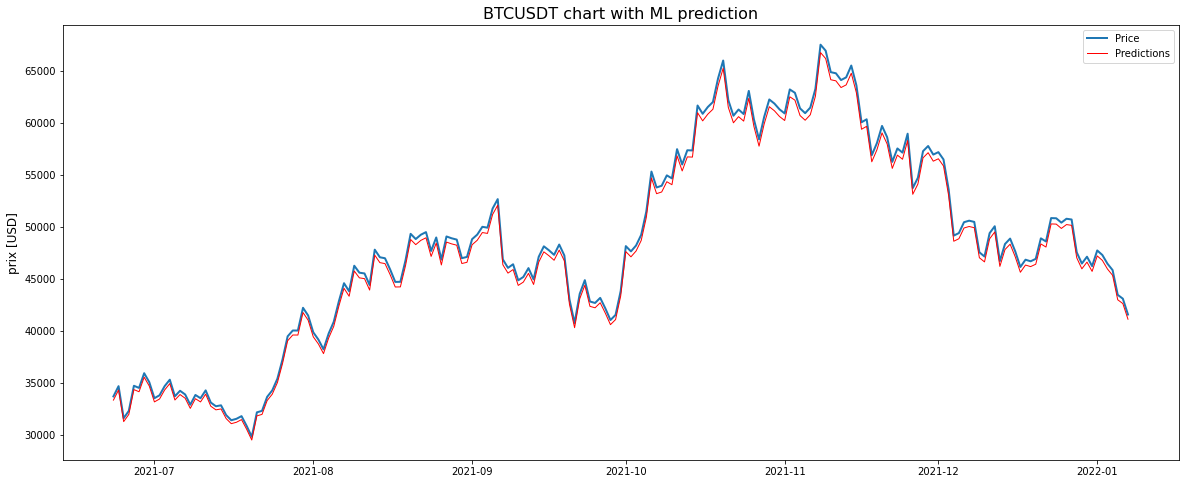

In [ ]:
df_pred = pd.DataFrame({"Real Price":X_test['Close Price']}) # On récupère nos données qu'on rentre dans un nouveau DataFrame
df_pred["Predictions"] = y_pred

# On affiche la prédiction et le cours réel sur les données de Test du dataset
fig, ax = plt.subplots(1, figsize=(20, 8))
ax.plot(df_pred['Real Price'], linewidth=2, label="Price")
ax.set_ylabel('prix [USD]', fontsize=12)
ax.plot(df_pred['Predictions'], linewidth=1, label="Predictions", color='r')
ax.set_title(symbol + " chart with ML prediction", fontsize=16)
ax.legend()
plt.show()

Enfin, voici le graphique final sur lequel sont combinés les prédictions réalisés par notre modèle et le vrai cours de la cryptomonnaie.

On remarque que la prédiction suit de prêt le cours, ce qui se reflettait sur les coefficients précédemment.
# -
*Alexis CERIO*

*ESILV Fintech A4*